# Spotify Song Popularity Prediction

This project implements a machine learning pipeline to predict the popularity of Spotify songs based on their audio features.  
It covers the full workflow from data loading and preprocessing to model training, evaluation, and insights.

The goal is to assess how much audio characteristics alone can explain song popularity — a challenging but insightful task demonstrating the strengths and limits of predictive modeling.

<img src="../Images/logo.png" alt="Logo" width="600">


## Table of Contents
1. [Setup and Imports](#1-setup-and-imports)
2. [Data Loading](#2-data-loading)
3. [Data Preprocessing & Feature Engineering](#3-data-preprocessing--feature-engineering)
4. [Exploratory Data Analysis](#4-exploratory-data-analysis)
5. [Model Training and Tuning](#5-model-training-and-tuning)
6. [Results and Conclusion](#6-results-and-conclusion)


## 1. Setup and Imports <a id='setup'></a>

Import core libraries for data processing, modeling, and visualization, and configure the environment.


In [66]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import joblib
from datetime import datetime
import math

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 700)

# Set plotting style
sns.set_theme(style="white")

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## 2. Data Loading <a id='data'></a>

Load the Spotify dataset, clean unnecessary columns, update data types.

- Load the raw dataset and drop irrelevant metadata columns.
- Update data types for efficiency and check for missing values.



**About the Data**

The dataset is sourced from the [Kaggle](https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs?select=spotify_songs.csv). It contains 32,833 songs and 23 features.

**Data Dictionary**

| Feature                  | Description                              |
|:--------------------------|:-----------------------------------------|
| track_id                  | Unique song ID                          |
| track_name                | Song name                               |
| track_artist              | Artist name                             |
| track_popularity          | Song popularity score (0–100)            |
| track_album_id            | Album unique ID                         |
| track_album_name          | Album name                              |
| track_album_release_date  | Album release date                      |
| playlist_id               | Playlist ID                             |
| playlist_name             | Playlist name                           |
| playlist_genre            | Playlist genre                          |
| playlist_subgenre         | Playlist subgenre                       |
| danceability              | Suitability for dancing (0.0–1.0)        |
| energy                    | Intensity and activity (0.0–1.0)         |
| key                       | Musical key (0=C, 1=C#/Db, etc.)         |
| loudness                  | Overall loudness in decibels             |
| mode                      | Modality: major (1) or minor (0)         |
| speechiness               | Presence of spoken words (0.0–1.0)       |
| acousticness              | Confidence track is acoustic (0.0–1.0)   |
| instrumentalness          | Likelihood track is instrumental (0.0–1.0) |
| liveness                  | Presence of a live audience (0.0–1.0)    |
| valence                   | Musical positiveness (0.0–1.0)           |
| tempo                     | Tempo in beats per minute (BPM)          |
| duration_ms               | Track duration in milliseconds          |

In [67]:
# Load the dataset
df = pd.read_csv('../data/spotify_songs.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset Shape: (32833, 23)

First few rows:


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [68]:
# Drop unnecessary columns
df.drop(columns=['track_id', 'track_name', 'track_artist', 'track_album_id', 'track_album_name', 'playlist_id', 'playlist_name'], inplace=True)

In [69]:
# Check data info
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_popularity          32833 non-null  int64  
 1   track_album_release_date  32833 non-null  object 
 2   playlist_genre            32833 non-null  object 
 3   playlist_subgenre         32833 non-null  object 
 4   danceability              32833 non-null  float64
 5   energy                    32833 non-null  float64
 6   key                       32833 non-null  int64  
 7   loudness                  32833 non-null  float64
 8   mode                      32833 non-null  int64  
 9   speechiness               32833 non-null  float64
 10  acousticness              32833 non-null  float64
 11  instrumentalness          32833 non-null  float64
 12  liveness                  32833 non-null  float64
 13  valence                   32833 non-null  float

In [70]:
# Define data types for each column
dtypes = {
    'track_popularity': 'int32',
    'track_album_release_date': 'datetime64[ns]',
    'playlist_genre': 'category', 
    'playlist_subgenre': 'category',
    'danceability': 'float32',
    'energy': 'float32',
    'key': 'int8',
    'loudness': 'float32', 
    'mode': 'category',
    'speechiness': 'float32',
    'acousticness': 'float32',
    'instrumentalness': 'float32',
    'liveness': 'float32',
    'valence': 'float32',
    'tempo': 'float32',
    'duration_ms': 'int32'
}

# Update data types
df = df.astype(dtypes)

Note: **'Key'** is a categorical variable but is encoded as an integer. More on this in the [Data Preprocessing & Feature Selection](#3-data-preprocessing--feature-engineering) section.


In [71]:
# Basic statistical description
df.describe()

,track_popularity,track_album_release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,42.477081,2011-08-07 17:30:40.185179648,0.654850,0.698619,5.374471,-6.719499,0.107068,0.175334,0.084747,0.190176,0.510561,120.881134,225799.811622
min,0.000000,1957-01-01 00:00:00,0.000000,0.000175,0.000000,-46.448002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,24.000000,2008-08-25 00:00:00,0.563000,0.581000,2.000000,-8.171000,0.041000,0.015100,0.000000,0.092700,0.331000,99.959999,187819.000000
50%,45.000000,2016-08-26 00:00:00,0.672000,0.721000,6.000000,-6.166000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984001,216000.000000
75%,62.000000,2019-04-19 00:00:00,0.761000,0.840000,9.000000,-4.645000,0.132000,0.255000,0.004830,0.248000,0.693000,133.917999,253585.000000
max,100.000000,2020-01-29 00:00:00,0.983000,1.000000,11.000000,1.275000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440002,517810.000000
std,24.984074,NaN,0.145085,0.180910,3.611657,2.988436,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624,59834.006182


In [72]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
track_popularity            0
track_album_release_date    0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64


The dataset appears to have no missing values. However, according to the data documentation, the `key` column has missing values encoded as `-1`. We will address this in the next section: 3. Data Preprocessing & Feature Selection.



## 3. Data Preprocessing & Feature Engineering <a id='preprocessing'></a>

**Encoding Cyclical Variable (Key) with Sine & Cosine**

**Key Definition**  
**`key`**: The estimated overall key of the track (0 = C, 1 = C♯/D♭, ..., 11 = B). If no key is detected, the value is `-1`.

Since **`key`** is **cyclical** (key 0 is adjacent to key 11), we encode it using **sine** and **cosine** transformations:

$$
\text{key\_sin} = \sin\!\Bigl(2\pi \cdot \frac{\text{key}}{12}\Bigr), \quad
\text{key\_cos} = \cos\!\Bigl(2\pi \cdot \frac{\text{key}}{12}\Bigr)
$$

**Why Both Sine & Cosine?**

1. **Preserving Cyclical Adjacency**  
   A single trigonometric function (e.g., only sine) flattens the cycle, losing the adjacency between key 11 and key 0. Using **both** sine and cosine maps each key to a **unique 2D point** on the unit circle, preserving distance.

2. **Avoiding Ambiguities**  
   Sine alone can yield the same value for two different keys (e.g., key \(k\) and \(k+6\)). Adding cosine prevents overlaps and fully represents the cycle.

**Handling `-1` for Key**

Tracks with `key = -1` (no key detected) have their `key_sin` and `key_cos` set to `NaN`, avoiding any misleading input into the model.


In [73]:
def preprocess_and_engineer_features(df):
    """
    Preprocess and engineer new features for the Spotify dataset.
    """
    df_featured = df.copy()

    # Encode 'key' as cyclical features
    if 'key' in df_featured.columns:
        df_featured['key_sin'] = np.sin(2 * np.pi * df_featured['key'] / 12)
        df_featured['key_cos'] = np.cos(2 * np.pi * df_featured['key'] / 12)
        df_featured.loc[df_featured['key'] == -1, ['key_sin', 'key_cos']] = np.nan
        df_featured.drop(columns='key', inplace=True)

    # Audio feature interactions
    if {'energy', 'danceability'}.issubset(df_featured.columns):
        df_featured['energy_dance_ratio'] = df_featured['energy'] / df_featured['danceability']
        df_featured['energy_dance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

    if {'acousticness', 'energy'}.issubset(df_featured.columns):
        df_featured['acoustic_energy_balance'] = df_featured['acousticness'] - df_featured['energy']

    if {'valence', 'energy'}.issubset(df_featured.columns):
        df_featured['mood_score'] = df_featured['valence'] * df_featured['energy']

    # Tempo categorization
    if 'tempo' in df_featured.columns:
        df_featured['tempo_category'] = pd.qcut(
            df_featured['tempo'], 
            4, 
            labels=['slow', 'medium', 'fast', 'very_fast']
        )

    # Release date features
    if 'track_album_release_date' in df_featured.columns:
        df_featured['track_album_release_date'] = pd.to_datetime(
            df_featured['track_album_release_date'], 
            errors='coerce'
        )
        df_featured['release_year'] = df_featured['track_album_release_date'].dt.year
        df_featured['release_month'] = df_featured['track_album_release_date'].dt.month
        df_featured['release_day'] = df_featured['track_album_release_date'].dt.day
        df_featured['track_age_years'] = datetime.now().year - df_featured['release_year']
        
        df_featured.drop(columns='track_album_release_date', inplace=True)

    return df_featured

# Engineer features
df_featured = preprocess_and_engineer_features(df)

# Display newly created features
print("New Features:")
new_features = [
    'key_sin', 'key_cos', 'energy_dance_ratio',
    'acoustic_energy_balance', 'mood_score', 
    'tempo_category', 'release_year', 'release_month',
    'release_day', 'track_age_years'
]
display(df_featured[new_features].head())


New Features:


,key_sin,key_cos,energy_dance_ratio,acoustic_energy_balance,mood_score,tempo_category,release_year,release_month,release_day,track_age_years
0,1.224647e-16,-1.000000,1.224599,-0.8140,0.474488,fast,2019,6,14,6
1,-5.000000e-01,0.866025,1.122589,-0.7426,0.564795,medium,2019,12,13,6
2,5.000000e-01,0.866025,1.379259,-0.8516,0.570703,fast,2019,7,5,6
3,-5.000000e-01,-0.866025,1.295265,-0.9013,0.257610,medium,2019,7,19,6
4,5.000000e-01,0.866025,1.281538,-0.7527,0.603925,fast,2019,3,5,6


In [74]:
# Define categorical and numerical feature sets
df_featured_categorical = df_featured.select_dtypes(include=['category']).columns.tolist()
df_featured_numerical = df_featured.select_dtypes(include=['int32', 'float32', 'float64']).columns.tolist()

print("Categorical Features:", df_featured_categorical)
print("Numerical Features:", df_featured_numerical)

Categorical Features: ['playlist_genre', 'playlist_subgenre', 'mode', 'tempo_category']
Numerical Features: ['track_popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'key_sin', 'key_cos', 'energy_dance_ratio', 'acoustic_energy_balance', 'mood_score', 'release_year', 'release_month', 'release_day', 'track_age_years']


## 4. Exploratory Data Analysis

This section explores the structure, distributions, and relationships within the Spotify dataset to better understand the data before modeling.

Key steps include:
- Analyzing distributions of numerical features.
- Identifying skewness, outliers, and data patterns.
- Examining feature correlations to detect multicollinearity.
- Investigating relationships between audio features and track popularity.
- Extracting insights to guide feature engineering and model selection.


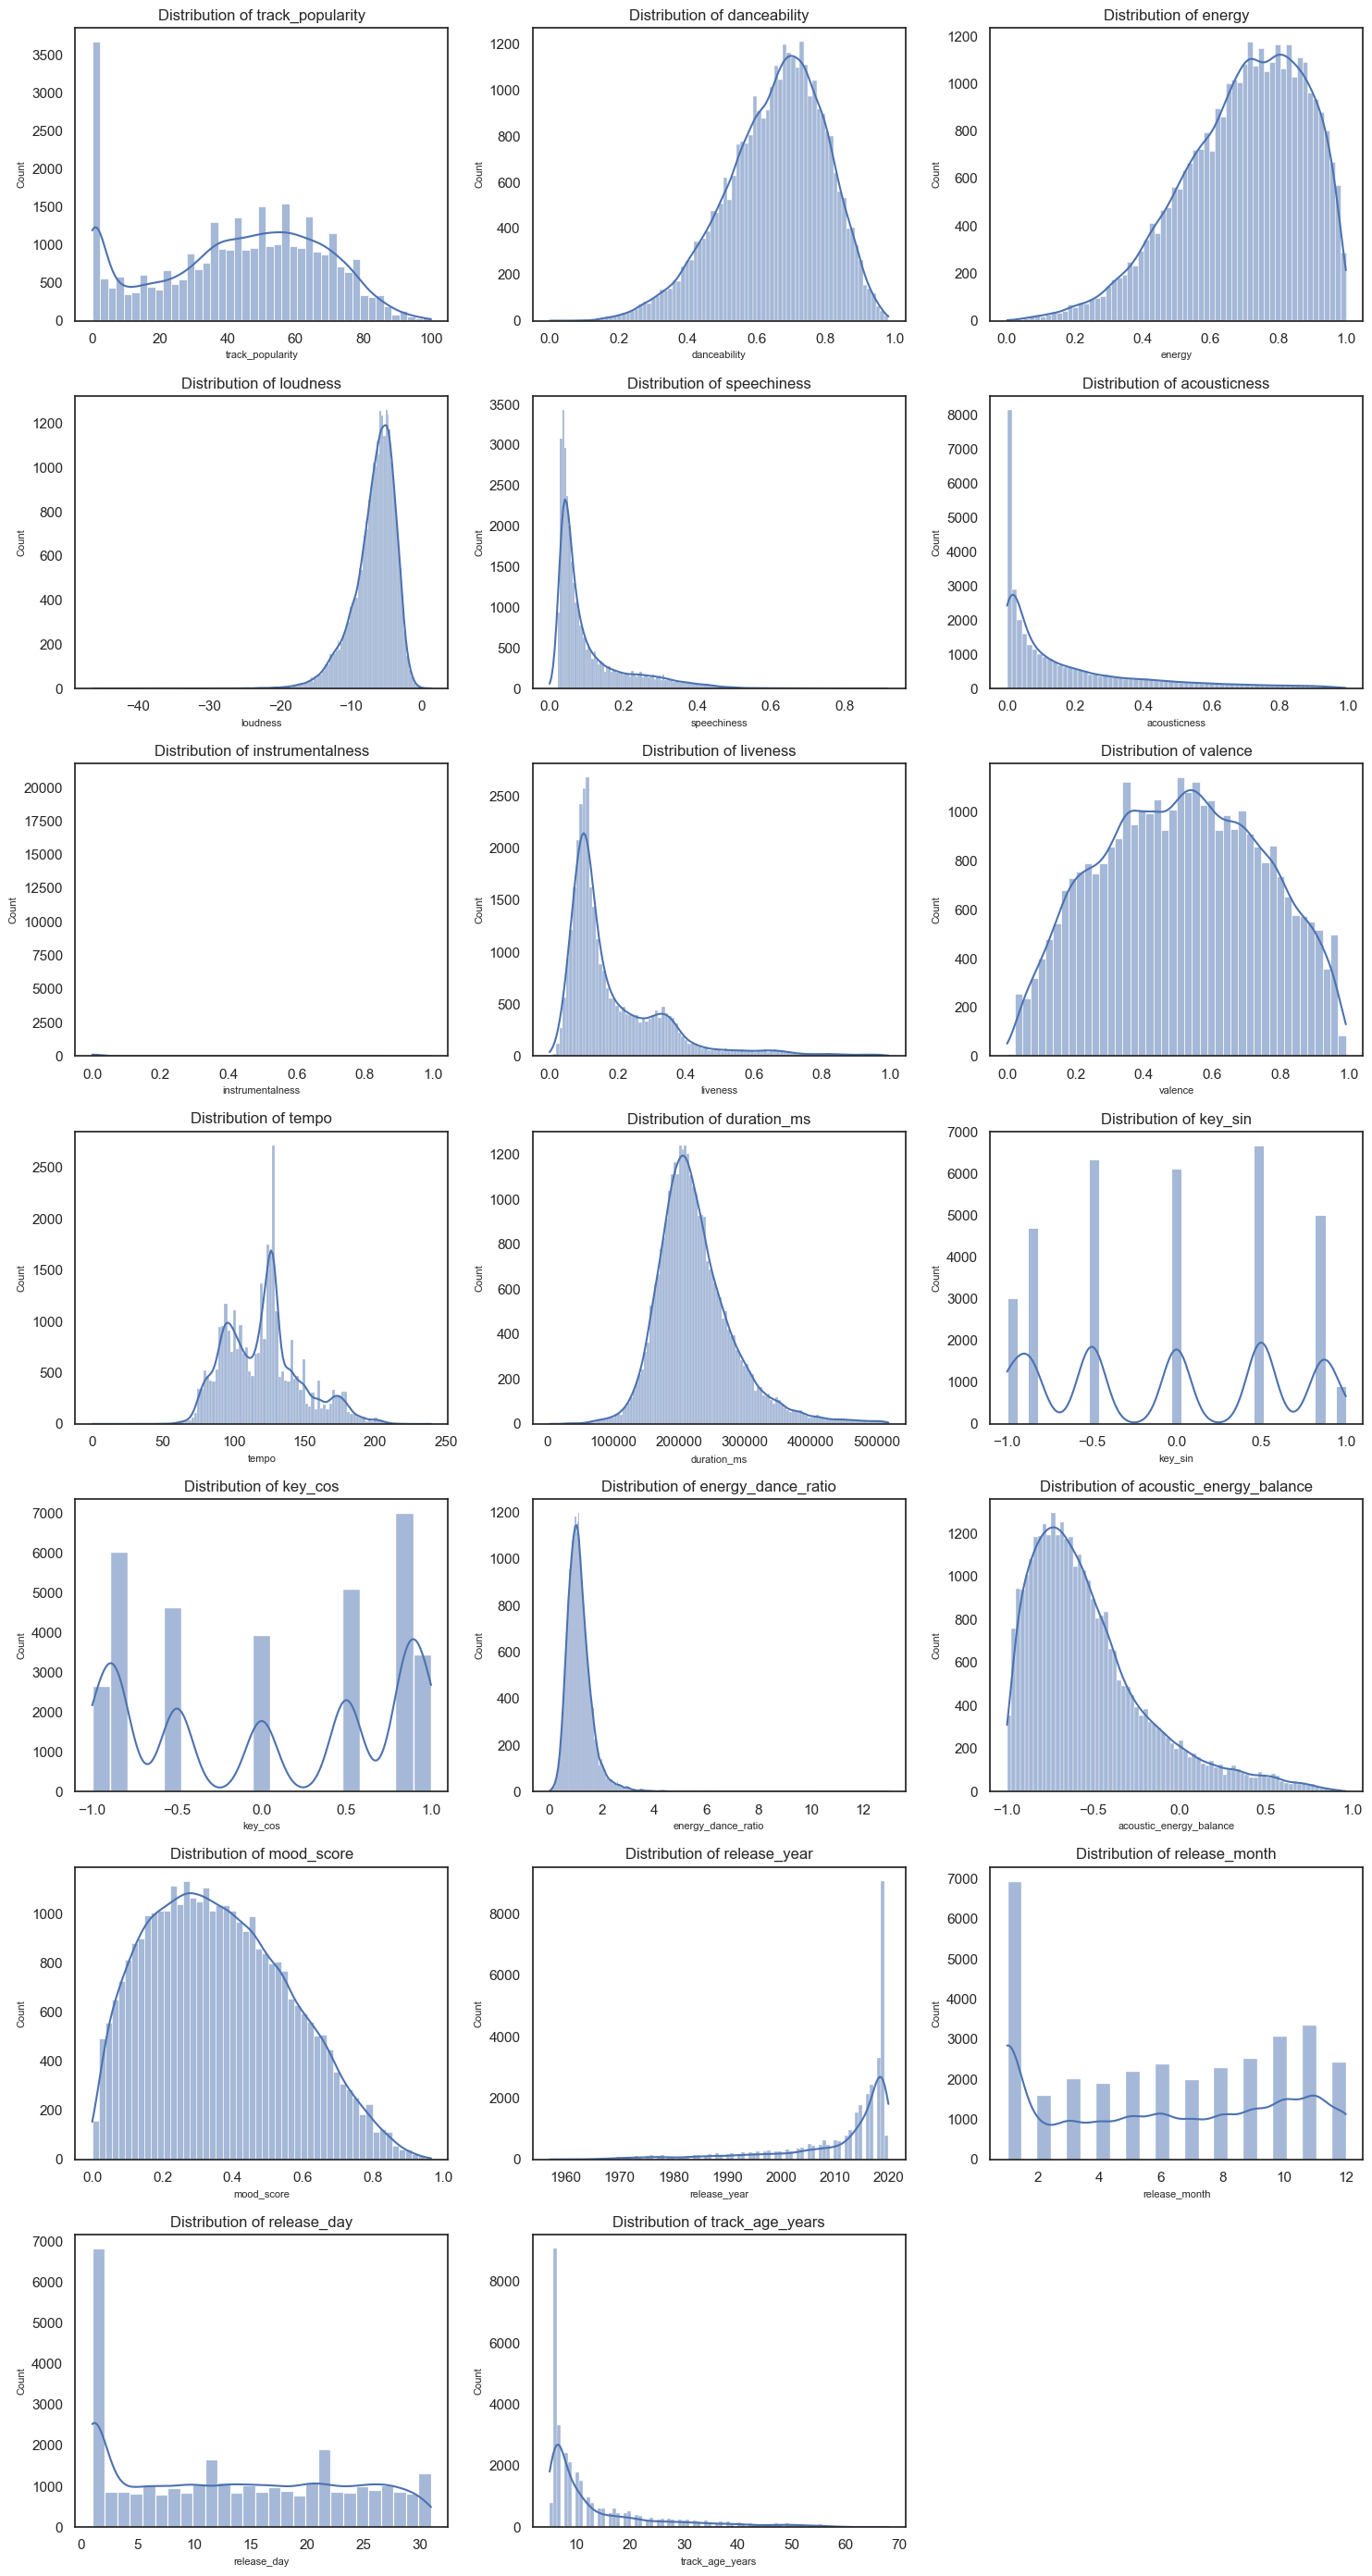

In [75]:
# Create a distribution plot for each numeric feature in df_featured
n_rows = (len(df_featured_numerical) + 2) // 3 
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, (ax, col) in enumerate(zip(axes, df_featured_numerical)):
    sns.histplot(data=df_featured, x=col, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col, fontsize=8)
    ax.set_ylabel('Count', fontsize=8)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


**Key observations from feature distributions:**

- **track_popularity** is heavily skewed toward lower values, but tree-based models handle imbalanced targets well.
- **Danceability**, **energy**, and **loudness** show strong central tendencies, offering useful splits for boosting models.
- **Speechiness**, **acousticness**, and **instrumentalness** are highly right-skewed, with many near-zero values, migh be strong binary-type signals.
- **Tempo** displays a bimodal pattern, suggesting clusters of slow and fast songs.
- **Valence** is relatively uniform, supporting rich splits across mood-related dimensions.
- **Key_sin** and **key_cos** exhibit expected cyclic patterns, preserving the music key structure.
- **Derived features** like **mood_score** and **energy_dance_ratio** are highly skewed but still informative for non-linear models.
- **Release year**, **release month**, and **track age** show that more recent releases dominate the dataset.

Overall, the dataset's feature diversity and skewed patterns are well-suited for tree-based modeling without further preprocessing.


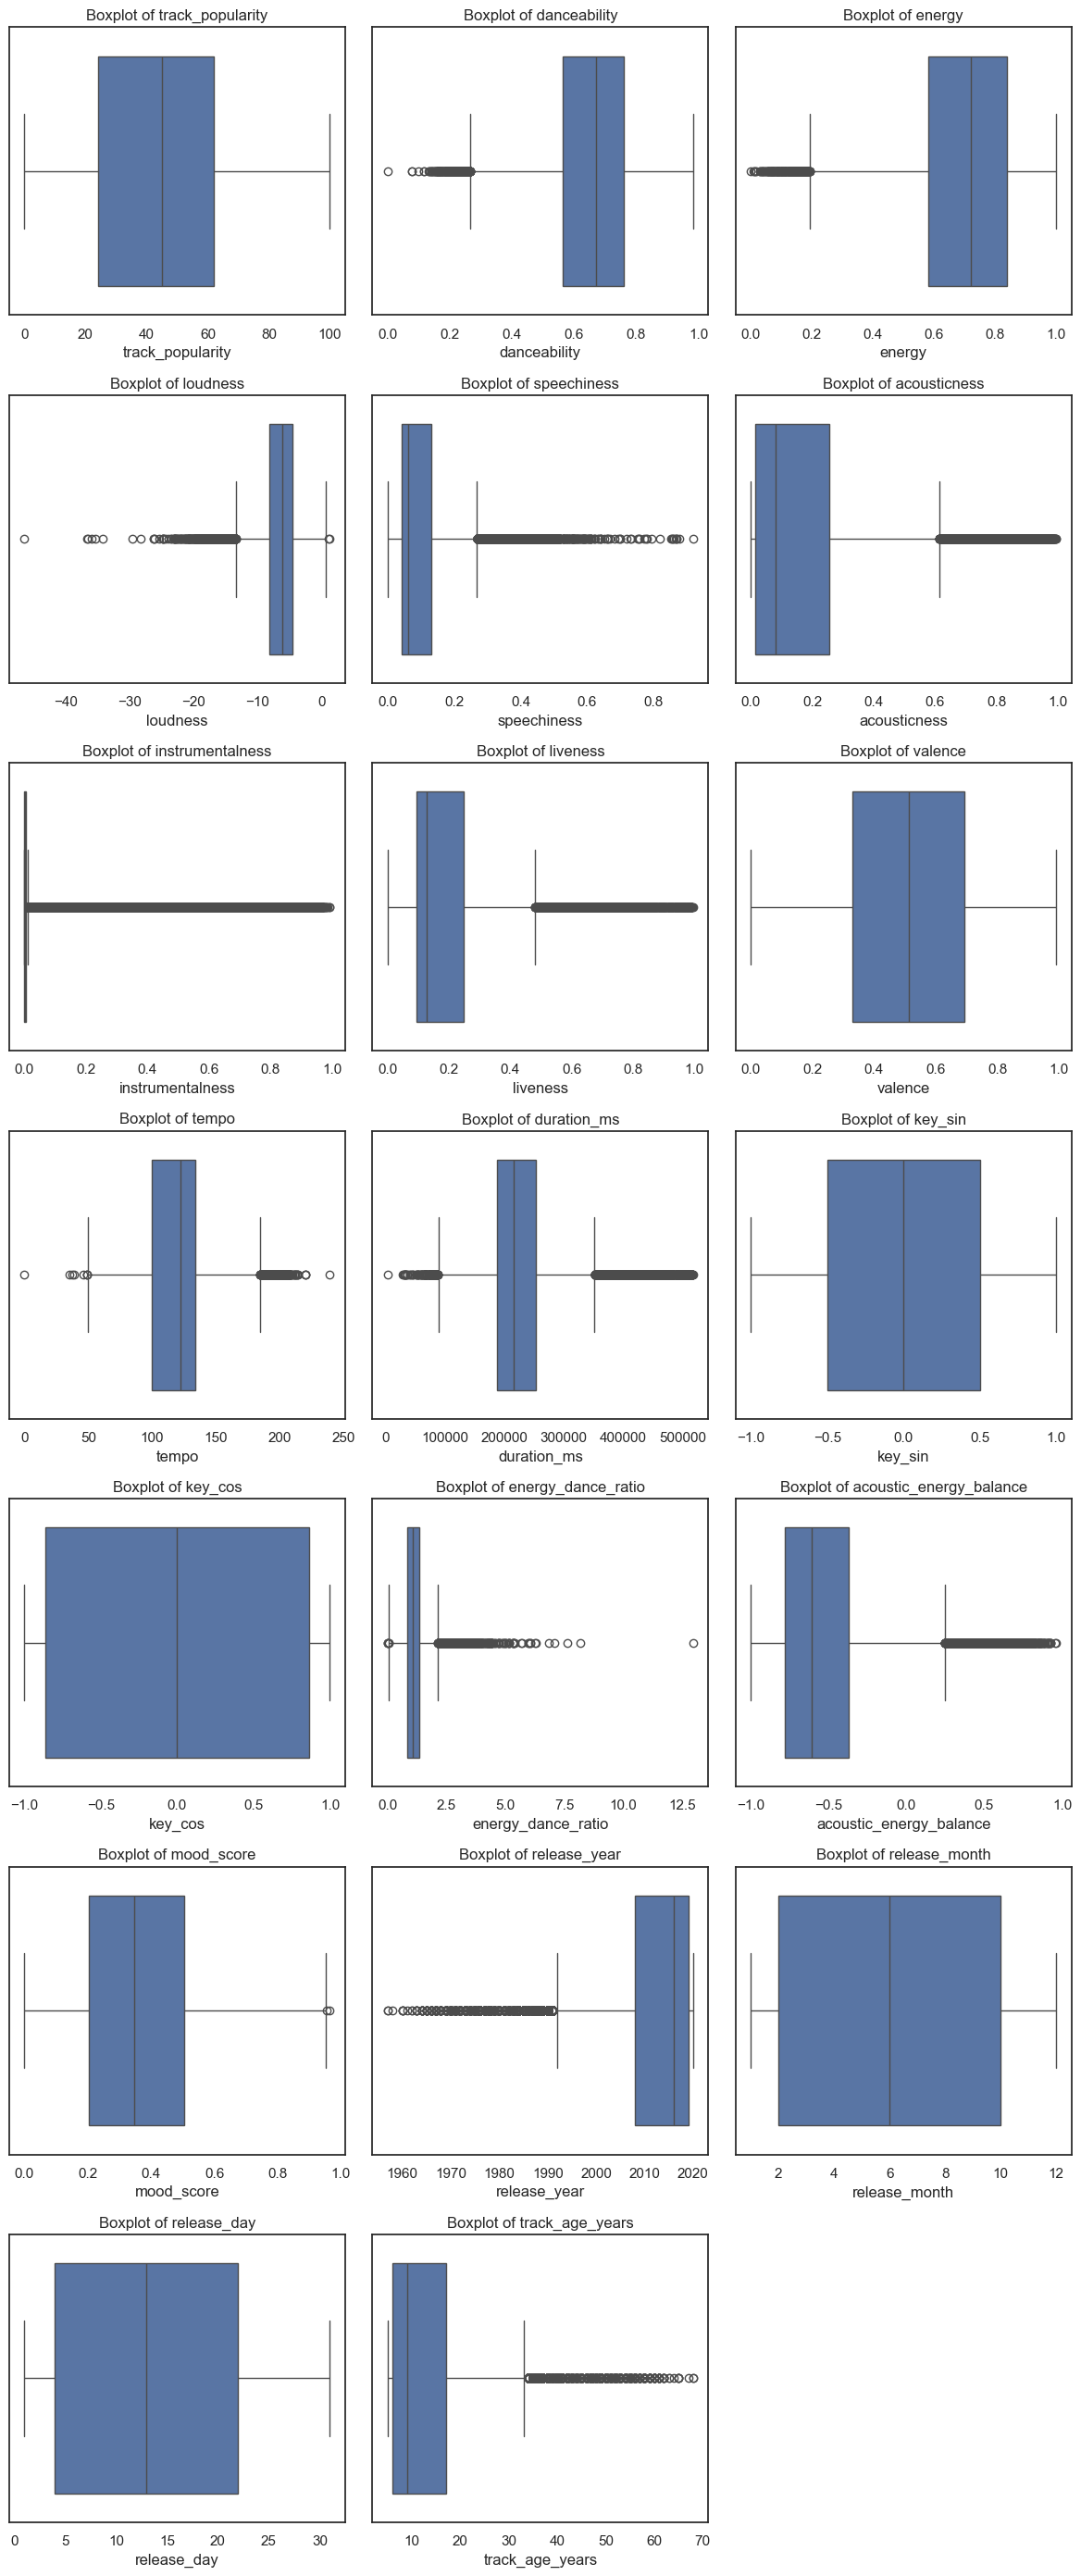

In [76]:
# Visualize outliers in numerical columns

n_rows = (len(df_featured_numerical) + 1) // 3
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(12, 4 * n_rows))
axes = axes.flatten() 

for i, (ax, col) in enumerate(zip(axes, df_featured_numerical)):
    sns.boxplot(data=df_featured, x=col, ax=ax)
    ax.set_title(f'Boxplot of {col}')

# Hide empty subplots if odd number of features
if len(df_featured_numerical) % 3 != 0:
    for ax in axes[len(df_featured_numerical):]:
        ax.set_visible(False)

plt.tight_layout()
plt.show()


**Outlier removal is not necessary for this project due to:**

1. Tree-based models (XGBoost, LightGBM, CatBoost) are inherently robust to outliers, as they partition data rather than fitting continuous curves.
2. Large dataset size minimizes the effect of extreme values on model training.
3. Outliers may carry valuable information, and removing them could discard meaningful patterns.
4. Categorical features are unaffected by outliers, and encoding methods handle variability naturally.
5. Regularization and loss functions in boosting models reduce outlier influence automatically.

Therefore, no explicit outlier cleaning is performed.


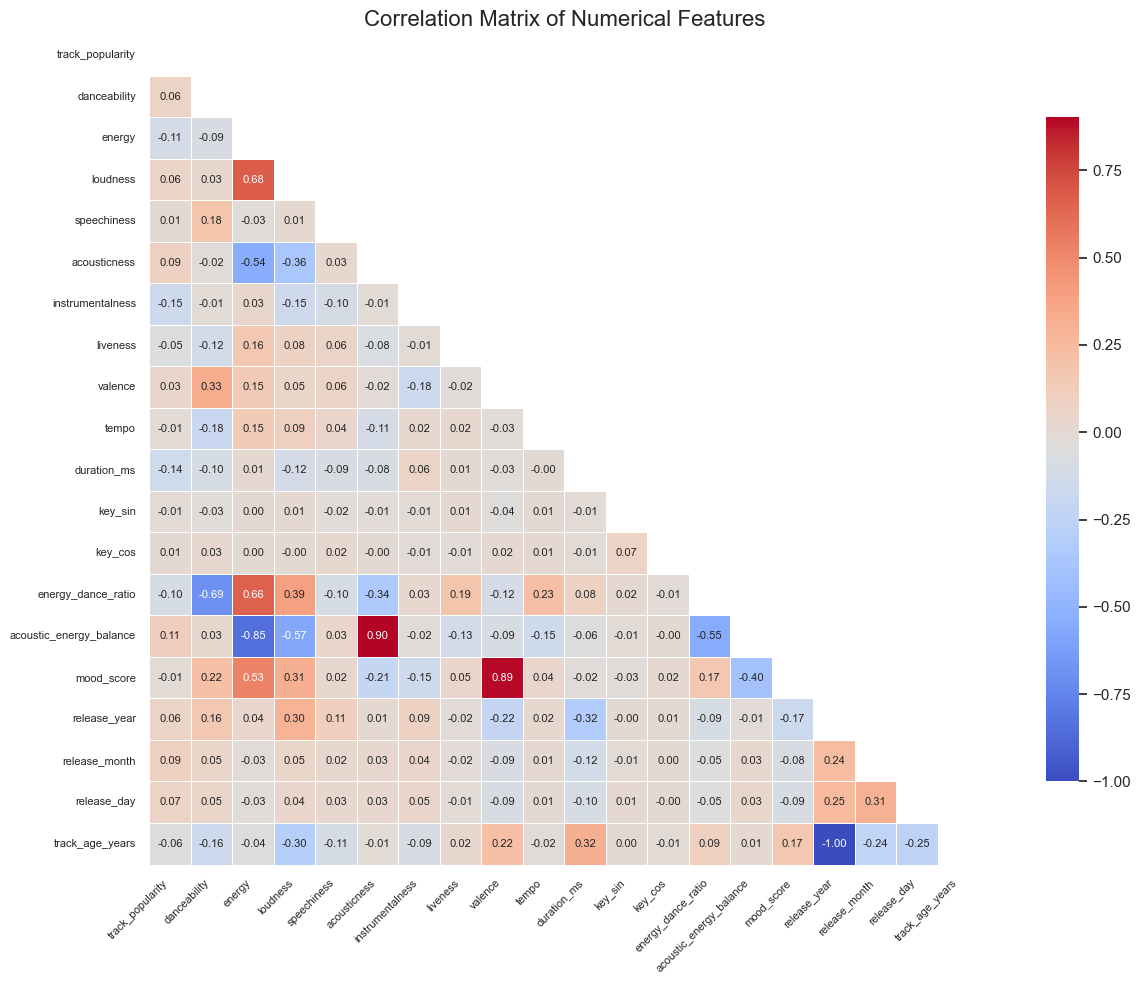

In [77]:
# Correlation matrix for numerical features
correlation_matrix = df_featured[df_featured_numerical].corr()

# Create a mask to show only the lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(14, 10))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 8}
)

plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


**Correlation Insights:**

- track_popularity shows very weak correlations with individual features, suggesting no single dominant predictor.
- energy and loudness are strongly correlated (0.68), reflecting the link between track intensity and volume.
- acousticness negatively correlates with energy (-0.54) and loudness (-0.36), consistent with quieter acoustic tracks.
- danceability moderately correlates with valence (0.33), indicating happier songs are often more danceable.
- Most features exhibit low pairwise correlations, minimizing multicollinearity concerns.
- The dataset's feature diversity supports the use of gradient boosting models without needing aggressive feature reduction.



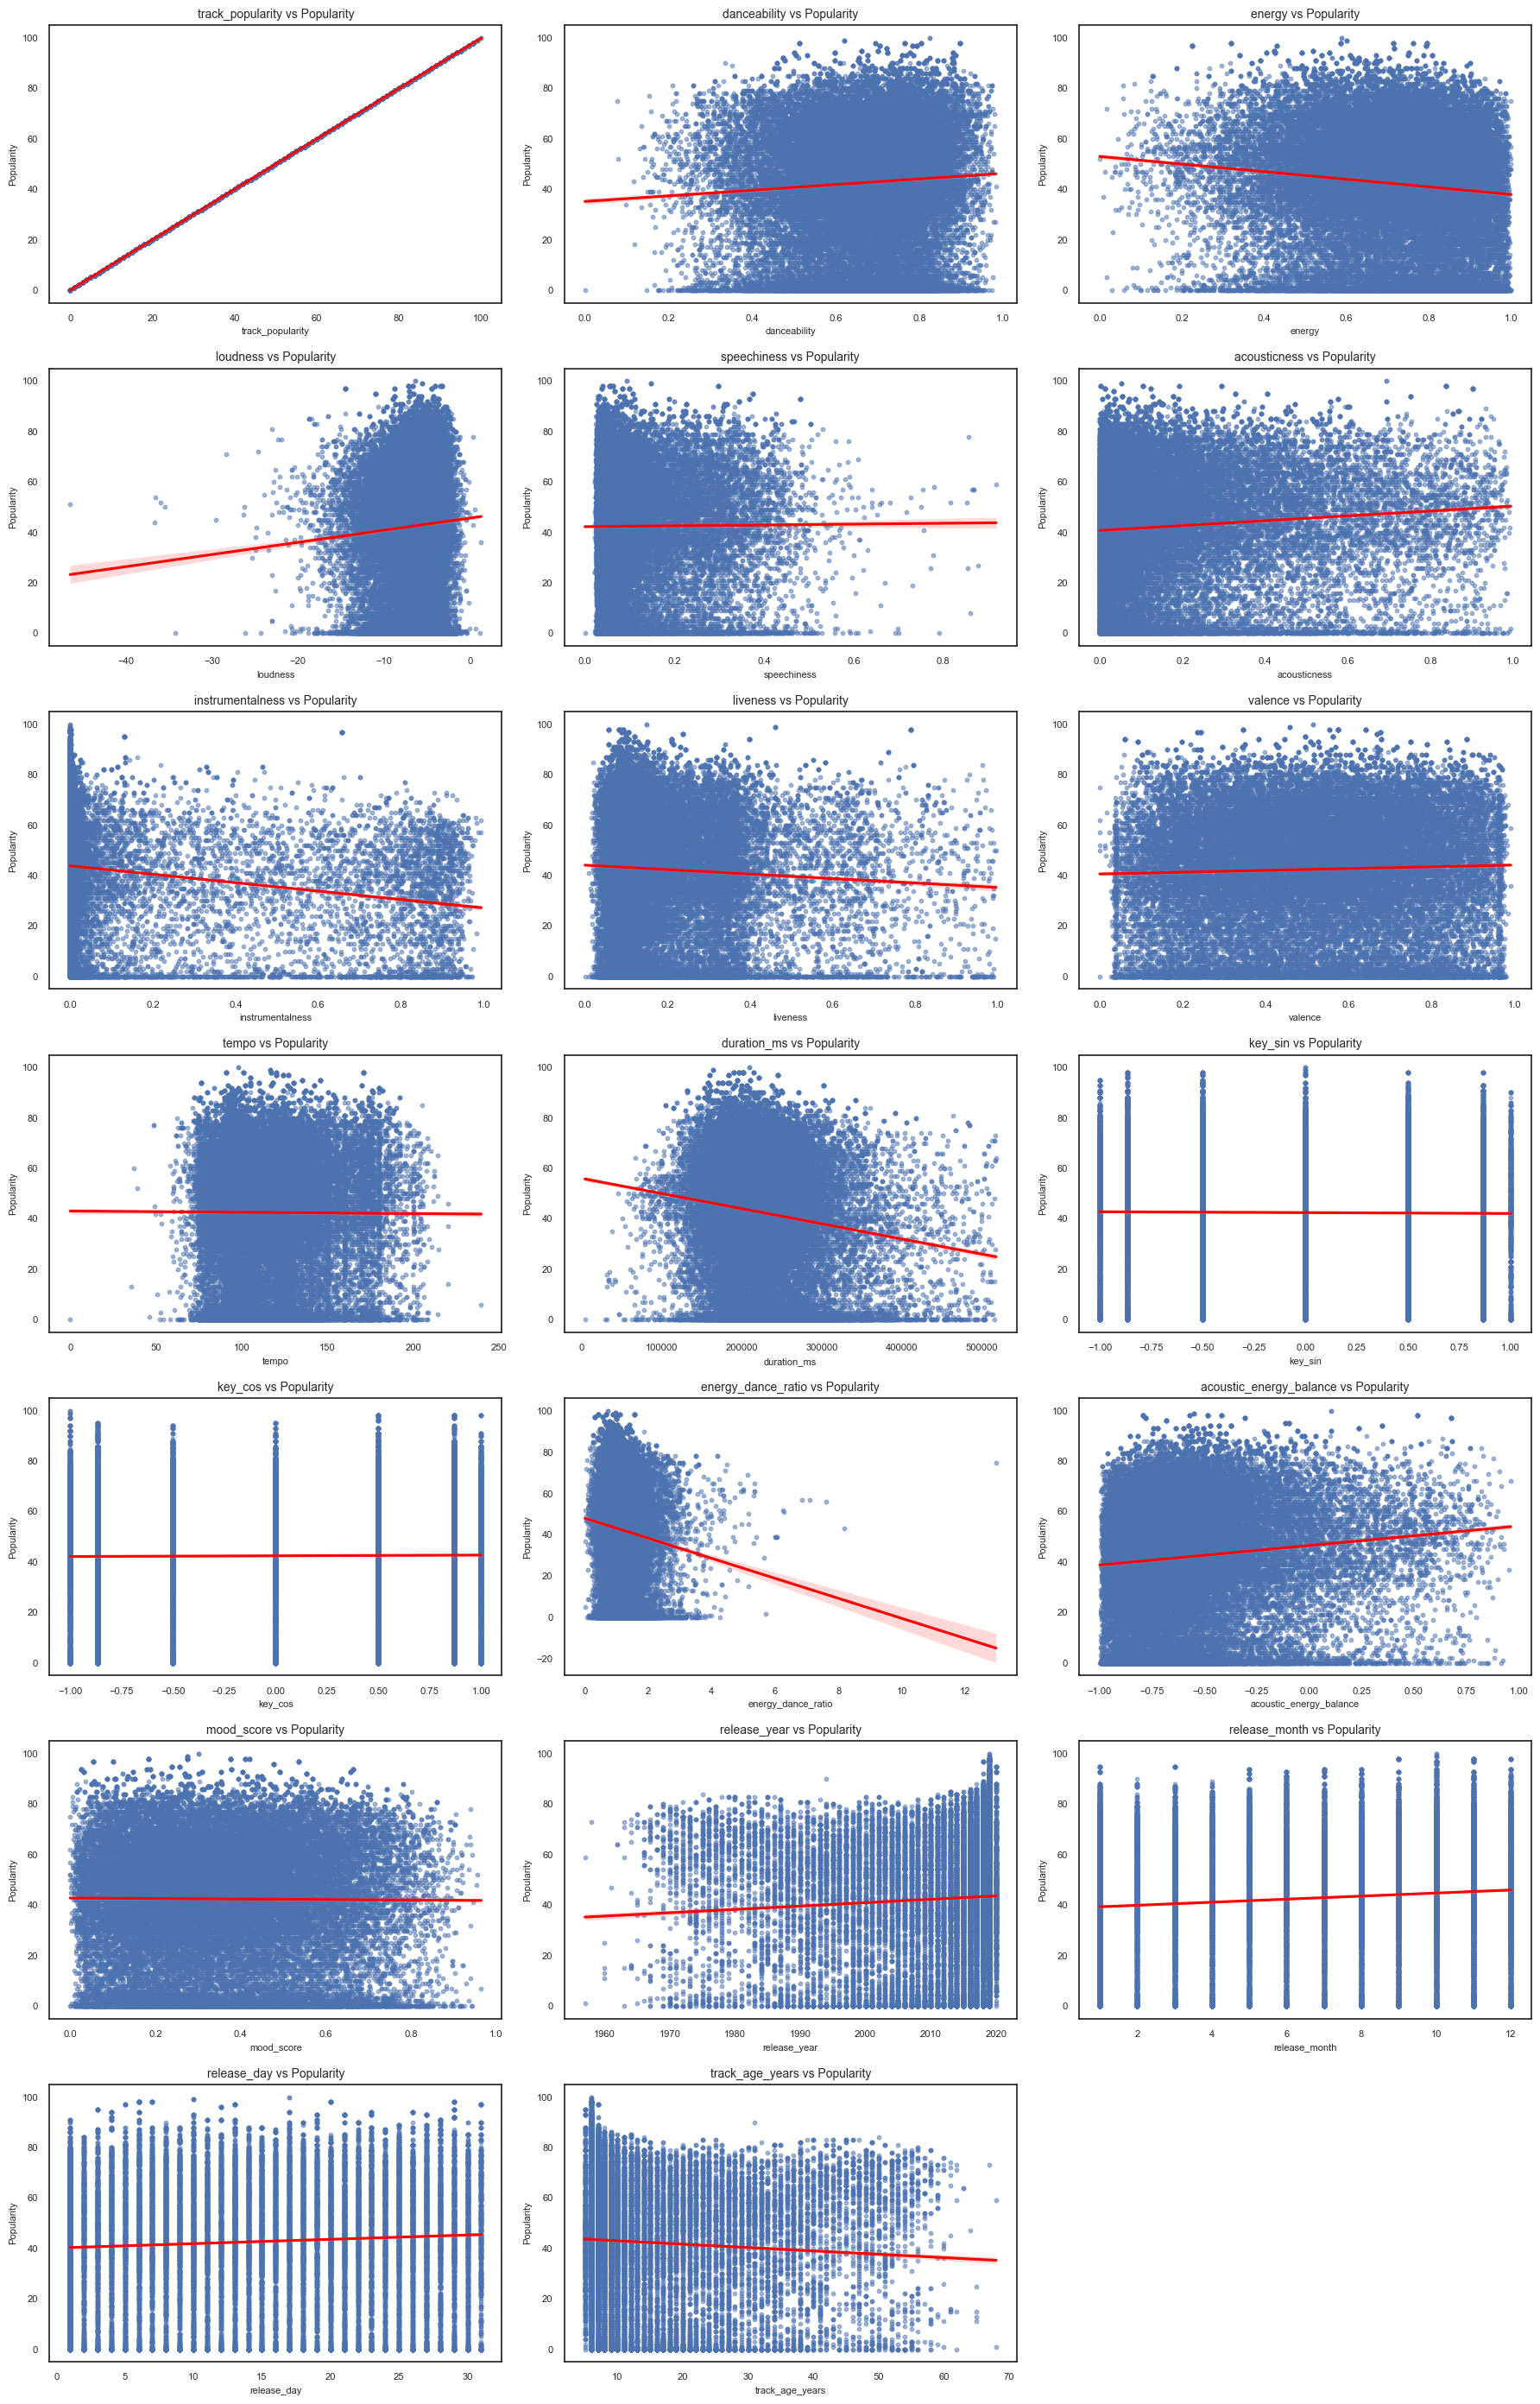

In [78]:
# Visualize the relationship between numerical features and track popularity
n_features = len(df_featured_numerical)
n_cols = 3  
n_rows = math.ceil(n_features / n_cols)  

plt.figure(figsize=(18, 4 * n_rows))  

for i, feature in enumerate(df_featured_numerical):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.regplot(
        data=df_featured, 
        x=feature, 
        y='track_popularity', 
        scatter_kws={'s': 10, 'alpha': 0.5},
        line_kws={'color': 'red'}
    )
    plt.title(f'{feature} vs Popularity', fontsize=10)
    plt.xlabel(feature, fontsize=8)
    plt.ylabel('Popularity', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()


**Interpritations of realtion with song popularity:**

- No single feature shows a strong linear relationship with track popularity.
- loudness, danceability, and valence have slightly positive trends, suggesting marginal influence.
- instrumentalness, energy, liveness, and duration_ms show slight negative relationships with popularity.
- Engineered features like mood_score and energy_dance_ratio also have weak or inverse trends, despite their conceptual relevance.
- Cyclical encodings (key_sin/cos) and release features (day/month/year) show minimal variation in popularity, with flat or near-random distributions.
- The near-zero slope of most trend lines reinforces that popularity is influenced by a complex interaction of multiple factors, rather than any one numerical feature alone.


## 5. Model Training and Evaluation <a id='training'></a>

This section builds and evaluates three gradient boosting models — XGBoost, LightGBM, and CatBoost — to predict song popularity based on audio and metadata features.

Each model is trained using a scikit-learn pipeline that includes:
- Preprocessing: Standard scaling for numerical features and one-hot encoding for categorical features.
- Hyperparameter tuning: Performed via GridSearchCV with 3-fold cross-validation.
- Model evaluation: Based on RMSE, R² score, MAE, and residual analysis on a held-out test set.

The goal is to identify the best-performing model and understand the predictive limits given the available features.


In [91]:
# Prepare features and target
X = df_featured.drop(columns='track_popularity')
y = df_featured['track_popularity']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numerical and categorical columns from training data
numerical_features = X_train.select_dtypes(include=['int32', 'float32', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()

In [92]:
# Train XGBoost model with categorical features
xgb_pipeline = Pipeline([
    ('preprocessing', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ]
    )),
    ('regressor', xgb.XGBRegressor(
        random_state=42,
        n_jobs=-1,
        verbosity=0,
        objective='reg:squarederror'
    ))
])

xgb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5],
    'regressor__learning_rate': [0.05, 0.1]
}

xgb_grid = GridSearchCV(
    xgb_pipeline,
    xgb_params,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train)

print("Best XGBoost parameters:", xgb_grid.best_params_)


Best XGBoost parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}


In [93]:
# Train LightGBM model with categorical features
lgb_pipeline = Pipeline([
    ('preprocessing', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ]
    )),
    ('regressor', lgb.LGBMRegressor(random_state=42))
])

# Hyperparameter grid for LightGBM
lgb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__num_leaves': [31, 63],
    'regressor__learning_rate': [0.01, 0.1]
}

# Grid search with 3-fold cross-validation
lgb_grid = GridSearchCV(
    estimator=lgb_pipeline,
    param_grid=lgb_params,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

# Fit the model
lgb_grid.fit(X_train, y_train)

# Best params
print("Best LightGBM parameters:", lgb_grid.best_params_)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3577
[LightGBM] [Info] Number of data points in the train set: 26266, number of used features: 55
[LightGBM] [Info] Start training from score 42.546334
Best LightGBM parameters: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 200, 'regressor__num_leaves': 63}


In [95]:
# Train CatBoost model with categorical features 
cat_pipeline = Pipeline([
    ('preprocessing', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ]
    )),
    ('regressor', CatBoostRegressor(
        random_state=42,
        verbose=0,
        task_type="CPU"
    ))
])

# Hyperparameter grid for CatBoost
cat_params = {
    'regressor__iterations': [100, 200],
    'regressor__depth': [4, 6],
    'regressor__learning_rate': [0.01, 0.1]
}

# Grid search
cat_grid = GridSearchCV(
    estimator=cat_pipeline,
    param_grid=cat_params,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

# Fit model
cat_grid.fit(X_train, y_train)

# Best parameters
print("Best CatBoost parameters:", cat_grid.best_params_)


Best CatBoost parameters: {'regressor__depth': 6, 'regressor__iterations': 200, 'regressor__learning_rate': 0.1}


In [96]:
# Model evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance with comprehensive metrics."""
    y_pred = model.predict(X_test)
    
    # Basic metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Calculate residuals
    residuals = y_test - y_pred
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.3f}")
    print(f"MAE: {mae:.2f}")
    print(f"Residual Range: [{residuals.min():.2f}, {residuals.max():.2f}]")
    
    return y_pred, residuals

# Evaluate the three models 
models = {
    'XGBoost': xgb_grid,
    'LightGBM': lgb_grid,
    'CatBoost': cat_grid}
        


XGBoost Performance Metrics:
RMSE: 21.10
R² Score: 0.283
MAE: 17.35
Residual Range: [-67.78, 55.44]

LightGBM Performance Metrics:
RMSE: 20.50
R² Score: 0.323
MAE: 16.74
Residual Range: [-65.02, 55.07]

CatBoost Performance Metrics:
RMSE: 21.42
R² Score: 0.261
MAE: 17.77
Residual Range: [-67.43, 52.80]


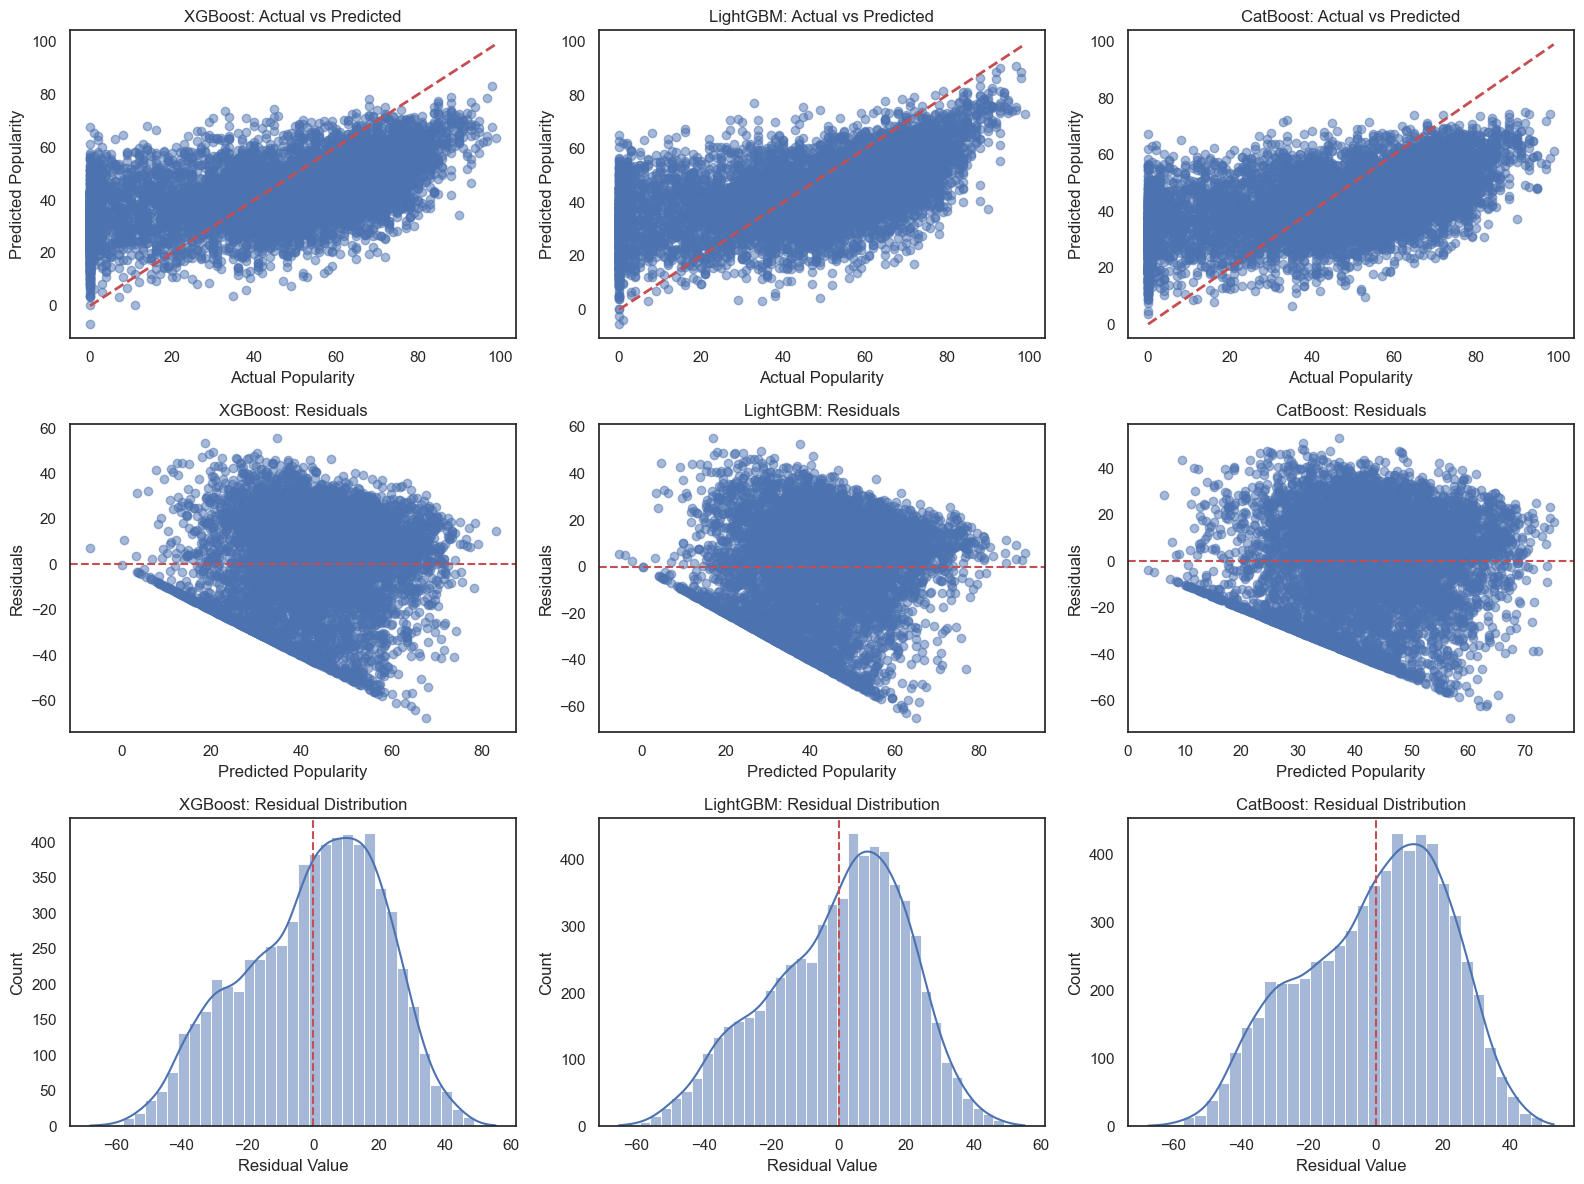

{'XGBoost': {'y_pred': array([43.16694 , 40.750313, 35.36671 , ..., 35.061943, 46.06325 ,
         40.857754], dtype=float32),
  'residuals': 30056     1.833061
  11827   -23.750313
  23571    -5.366711
  14741     5.632969
  25570    31.520721
             ...    
  18220     5.529472
  28878   -15.722609
  11570   -33.061943
  1662    -46.063251
  8025     -0.857754
  Name: track_popularity, Length: 6567, dtype: float64},
 'LightGBM': {'y_pred': array([44.50000913, 34.61907095, 36.35348216, ..., 31.61828241,
         50.99002033, 40.08598174]),
  'residuals': 30056     0.499991
  11827   -17.619071
  23571    -6.353482
  14741     8.555466
  25570    37.961073
             ...    
  18220     5.532780
  28878   -12.987586
  11570   -29.618282
  1662    -50.990020
  8025     -0.085982
  Name: track_popularity, Length: 6567, dtype: float64},
 'CatBoost': {'y_pred': array([45.34247181, 42.41211409, 38.51955281, ..., 33.84813   ,
         51.16250789, 40.51614453]),
  'residuals': 30056 

In [98]:
# Plot model comparisons function
def plot_model_comparisons(models, X_test, y_test):
    """Create comprehensive comparison visualizations for multiple models."""
    # Store results
    results = {}
    
    plt.figure(figsize=(16, 12))
    
    # Evaluate each model
    for i, (model_name, model) in enumerate(models.items()):
        y_pred, residuals = evaluate_model(model, X_test, y_test, model_name)
        results[model_name] = {'y_pred': y_pred, 'residuals': residuals}
        
        # Actual vs Predicted plot
        plt.subplot(3, 3, i+1)
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.title(f'{model_name}: Actual vs Predicted')
        plt.xlabel('Actual Popularity')
        plt.ylabel('Predicted Popularity')
        
        # Residuals plot
        plt.subplot(3, 3, i+4)
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title(f'{model_name}: Residuals')
        plt.xlabel('Predicted Popularity')
        plt.ylabel('Residuals')
        
        # Residual distribution
        plt.subplot(3, 3, i+7)
        sns.histplot(residuals, kde=True)
        plt.axvline(x=0, color='r', linestyle='--')
        plt.title(f'{model_name}: Residual Distribution')
        plt.xlabel('Residual Value')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Plot model comparisons
plot_model_comparisons(models, X_test, y_test)

## 6. Results and Conclusion

**Model Performance**

Three gradient boosting models — XGBoost, LightGBM, and CatBoost — were trained to predict Spotify song popularity based on audio features.  
Key evaluation metrics on the test set:

| Model     | RMSE   | R² Score | MAE   |
|:----------|:------:|:--------:|:-----:|
| XGBoost   | 21.10  | 0.283    | 17.35 |
| LightGBM  | 20.50  | 0.323    | 16.74 |
| CatBoost  | 21.42  | 0.261    | 17.77 |

- **LightGBM** achieved the best overall performance, with the lowest RMSE and highest R² score.
- **XGBoost** closely followed, while **CatBoost** underperformed slightly compared to the others.

**Interpretation**

While the models captured some structure in the data, overall performance remained modest:
- R² scores around 0.26–0.32 indicate that the models explain only about 30% of the variation in song popularity.
- Typical prediction errors (MAE ~17) are large relative to the 0–100 popularity scale.
- Residuals show high variance, confirming that many factors influencing popularity are not present in the dataset.

**Conclusion**

Predicting Spotify song popularity based solely on audio features is inherently challenging:
- Popularity is driven by a complex mix of external factors such as marketing, social media trends, and artist fame — none of which are captured here.
- Audio attributes like danceability, energy, and valence show weak correlations with popularity individually.

Despite these challenges, the project successfully demonstrated:
- The practical use of advanced machine learning techniques (XGBoost, LightGBM, CatBoost) on real-world data.
- Robust model evaluation through cross-validation, hyperparameter tuning, and residual analysis.
- Realistic limitations when modeling complex social phenomena with limited feature sets.

Future improvements could include incorporating external metadata (e.g., artist popularity, playlist followers) or reframing the problem as a classification task (e.g., predicting Top 100 hits).

